In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
# Setup output and imports
from tslib import ts_import, ts_output, ts_log, ts_csvout
PROG = "pplate-defl-optim"   # This experiment's ID
OUT_D = ts_output(PROG)      # Output file directory

# import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

from scipy.optimize import minimize, root_scalar

libem = ts_import("libem", "20211006")
cmp = ts_import("components", "20211006")
rlm = ts_import("realmodel", "latest")
libvis = ts_import("libvis", "latest")

Results directory already exists: results\pplate-defl-optim20211018
tslib.realmodel_20211004
tslib.libvis_20211018


## Set up dimensions and conversions

In [3]:
conv = rlm.Conversion(
    mass=1, # kg (1amu) / sim unit
    length=1, #1cm / sim unit
    time=1,
    charge=1,
    voltage=1
)

# Goal for deflection voltage is 10V for 200eV ions

DFDIM = {
    "length": conv.real_to_sim(3, "length"), # ideal is 3cm
    "box": conv.real_to_sim(2, "length"),
    "diam": conv.real_to_sim(1, "length"),
    "boxwall": conv.real_to_sim(0.2, "length"),

    "panel_l": conv.real_to_sim(1, "length"),
    "panel_w": conv.real_to_sim(1.6, "length"),
    "panel_h": conv.real_to_sim(0.2, "length"),
    "panel_gap": conv.real_to_sim(1.1, "length")
}

set_panel_sheight = lambda h: h - (DFDIM["box"] / 2.0)

SPACE_SIZE = [round(DFDIM["length"] * 1.5), round(DFDIM["box"] * 1.5), round(DFDIM["box"] * 1.5)]
SPACE_TLFT = [-(s / 2.0) for s in SPACE_SIZE]

SCALE = 20

ts_log(PROG, "SIMULATION SPACE SIZE:", ", ".join([str(s) for s in SPACE_SIZE]))
ts_log(PROG, "SIMULATION SPACE TOP_LEFT:", ", ".join([str(tl) for tl in SPACE_TLFT]))
ts_log(PROG, "SIMULATION SCALE SET AT:", SCALE)


SIMULATION SPACE SIZE: 4, 3, 3
SIMULATION SPACE TOP_LEFT: -2.0, -1.5, -1.5
SIMULATION SCALE SET AT: 20


## Gate generator

In [4]:
def generate_dfgate(panel_pos, panel_dim, body_V, hole_V, electrode_V):
    # Create simulation space from global parameters
    sim = libem.EMSimulationSpace3D(space_size=SPACE_SIZE, top_left=SPACE_TLFT, scale=SCALE)

    # CREATE GATE COMPONENTS
    # Body - Hollow Rectangular Prism
    body = (
        (-(DFDIM["length"] / 2.0), -(DFDIM["box"] / 2.0), -(DFDIM["box"] / 2.0)),
        (DFDIM["length"], DFDIM["box"], DFDIM["box"]),
        DFDIM["boxwall"],
        body_V
    )
    # End Holes - Closed Cylinders
    ehole_0_mask = cmp.EMObjectMasks.closed_cylinder_in_plane(
        sim,
        (-(DFDIM["length"] / 2.0), 0, 0),
        DFDIM["diam"] / 2.0,
        DFDIM["boxwall"],
        0
    )
    ehole_1_mask = cmp.EMObjectMasks.closed_cylinder_in_plane(
        sim,
        ((DFDIM["length"] / 2.0), 0, 0),
        DFDIM["diam"] / 2.0,
        DFDIM["boxwall"],
        0,
        direction=-1
    )
    # Deflection Panel - Rectangular Prism
    top_panel = (
        (*panel_pos[:2], panel_pos[2] + DFDIM["panel_gap"]),
        panel_dim,
        -electrode_V
    )
    bottom_panel = (
        panel_pos,
        panel_dim,
        electrode_V
    )

    # Generate boundary enforcer
    enf = [
        cmp.enf(+1, cmp.EMObjects.rectangular_prism_hollow, *body),
        cmp.enf(-1, cmp.EMObjects.arbitrary_mask, ehole_0_mask, hole_V),
        cmp.enf(-1, cmp.EMObjects.arbitrary_mask, ehole_1_mask, hole_V),
        cmp.enf(+1, cmp.EMObjects.rectangular_prism_solid, *top_panel),
        cmp.enf(+1, cmp.EMObjects.rectangular_prism_solid, *bottom_panel)
    ]

    return sim, enf


## Visualize Particle Path

Visualizing the deflection gate with particle path.
 - Computing electric field
 - Computing particle motion
 - Rendering 2D Electric Field Cross-Sections at 0 with Motion
Particle path experiment ran.


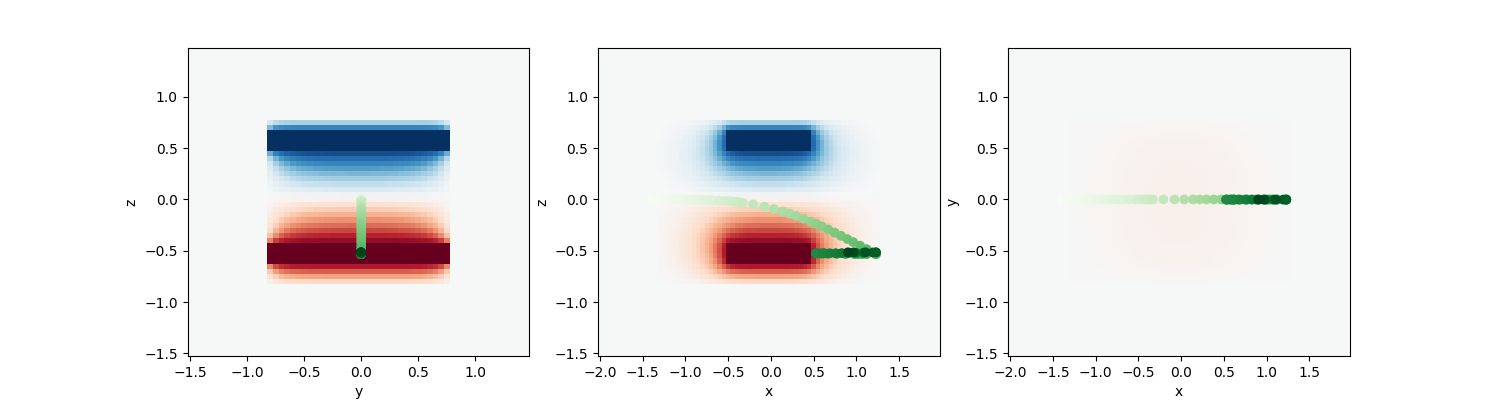

In [5]:
PARTICLE_OPTS = {
    "mass": (conv.real_to_sim(1, "mass"), 0),
    "charge": (conv.real_to_sim(1, "charge"), 0),
    "initial_loc": ((conv.real_to_sim(-1.4, "length"), 0, 0), (0, 0, 0)),
    "initial_v": ((conv.real_to_sim(1, "length / time"), 0, 0), (0, 0, 0)),
    "bounce_coef": 1
}

def visualize_dfgate_particle(particle_opts, panel_pos, body_V, hole_V, electrode_V):
    V_norm = max(abs(electrode_V), abs(hole_V), abs(body_V), 0.1)

    print("Visualizing the deflection gate with particle path.")
    sim, enf = generate_dfgate(
        panel_pos,
        (DFDIM["panel_l"], DFDIM["panel_w"], DFDIM["panel_h"]),
        body_V, hole_V, electrode_V)
    print(" - Computing electric field")
    sim.compute(enf)
    sim.get_efield()
    print(" - Computing particle motion")
    particle = libem.ChargedParticle3D(sim, particle_opts["mass"][0], particle_opts["charge"][0],
                                       (particle_opts["initial_loc"][0][0], 0, 0),
                                       particle_opts["initial_v"][0], bounce=particle_opts["bounce_coef"])
    particle.compute_motion((0, (DFDIM["length"] * 1.5) / particle_opts["initial_v"][0][0]))
    print(" - Rendering 2D Electric Field Cross-Sections at 0 with Motion")


    
    _, axs = plt.subplots(1, 3, figsize=(15, 4))
    labels = ["x", "y", "z"]
    for i, ax in enumerate(axs):
        sub_label = labels[:]
        sub_label.pop(i)
        ax.set_xlabel(sub_label[0])
        ax.set_ylabel(sub_label[1])

        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=0)
        libvis.Visualizations.colormesh_2d(sim2d, color_norm=V_norm, graph_ax=ax)
        libvis.Visualizations.trajectory_2d(particle.time, particle.position, axis=i, graph_ax=ax)

    # Save the simulation results
    # Columns: MASS, CHARGE, X_0, Vx_0, Vy_0, Vz_0, BOUNCE, X_1, Y_1, Z_1
    ts_csvout(PROG, "particle_paths.csv",
        [particle_opts["mass"][0], particle_opts["charge"][0], particle_opts["initial_loc"][0][0], *particle_opts["initial_v"][0],
        particle_opts["bounce_coef"], *particle.position.T[-1]]
    )
    # Save image
    plt.savefig(OUT_D + "/ppath.png")
    # Log
    ts_log(PROG, "Particle path experiment ran.")


visualize_dfgate_particle(
    PARTICLE_OPTS,
    (-(DFDIM["panel_l"] / 2.0), -(DFDIM["panel_w"] / 2.0), (set_panel_sheight(0.4))),
    0, 0, -0.15
)


Parameters: 1.5 1.0
   0.0 -> 1.6
   0.5 -> -0.83
   0.25 -> -1.09
   0.078 -> 1.49
   0.164 -> -1.13
   0.107 -> -0.98
=> Minimum V found:  0.107
Parameters: 1.75 1.0
   0.0 -> 1.6
   0.5 -> -0.83
   0.25 -> -0.58
   0.138 -> -1.13
   0.069 -> 1.5
   0.113 -> -1.63
=> Minimum V found:  0.113
Parameters: 1.5 1.25
   0.0 -> 1.6
   0.5 -> -0.56
   0.25 -> -0.39
   0.155 -> -1.13
   0.077 -> 1.52
   0.13 -> -1.25
   0.103 -> -0.77
   0.102 -> -0.75
=> Minimum V found:  0.102
Parameters: 1.5 1.0
   0.0 -> 1.6
   0.5 -> -0.83
   0.25 -> -1.09
   0.078 -> 1.49
   0.164 -> -1.13
   0.107 -> -0.98
=> Minimum V found:  0.107
Optimal result achieved.
Length: 1.5 Gap: 1.0
 => Voltage: 0.10696066196920151


(1.5, 1.0, 0.10696066196920151)

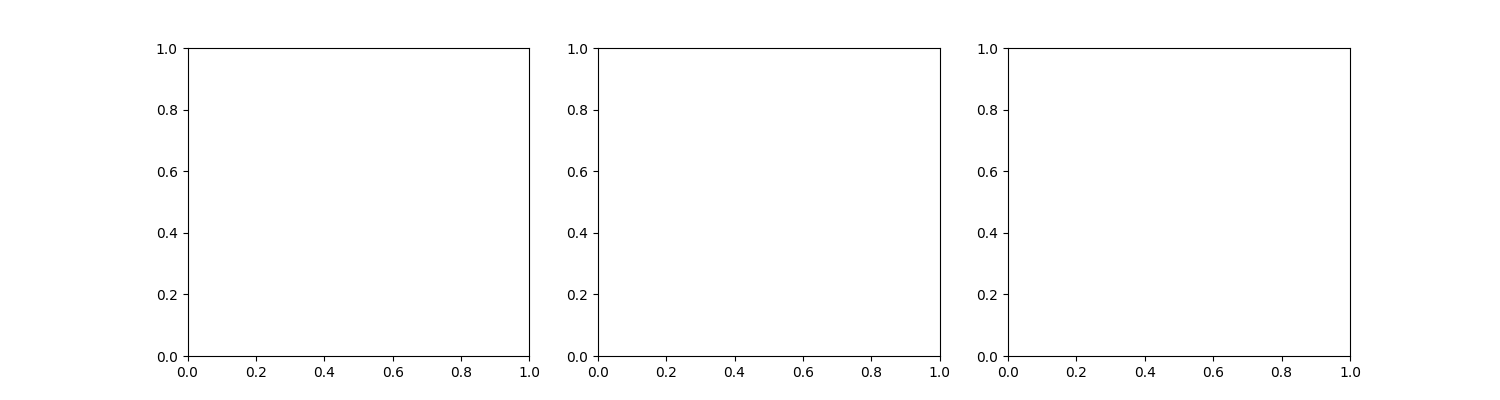

In [7]:
def minimize_defl_V(particle_opts, panel_l=(0.1, 2.8), panel_g=(1, 1.5), visualize=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    video = libvis.VideoMaker(fig, axs)

    qKe = particle_opts["charge"][0] * (particle_opts["mass"][0] / 2.0) * (particle_opts["initial_v"][0][0]**2)

    ts_csvout(
        PROG,
        "minimize_v.csv",
        ["PARTICLE_QKE", "PLATE_L", "PLATE_GAP", "PLATE_V", "SUCCESS_METRIC"],
        append=False
    )

    def stop_fn(V, l, g):
        # Returns a negative value if stopped "too soon", or a positive one if the particle escapes.
        sim, enf = generate_dfgate(
            (-(DFDIM["length"] / 2.0) + DFDIM["boxwall"], -(DFDIM["box"] / 2.0) + DFDIM["boxwall"], -(g / 2.0)),
            (l, DFDIM["panel_w"] - (2 * DFDIM["boxwall"]), DFDIM["panel_h"]),
            0, 0, V)

        sim.compute(enf)
        sim.get_efield()

        particle = libem.ChargedParticle3D(sim, particle_opts["mass"][0], particle_opts["charge"][0],
                                        (particle_opts["initial_loc"][0][0], 0, 0),
                                        particle_opts["initial_v"][0], bounce=particle_opts["bounce_coef"])
        particle.compute_motion((0, (DFDIM["length"] * 1.5) / particle_opts["initial_v"][0][0]))

        if visualize:
            video.new_frame()

            labels = ["x", "y", "z"]
            for i, ax in enumerate(axs):
                sub_label = labels[:]
                sub_label.pop(i)
                ax.set_xlabel(sub_label[0])
                ax.set_ylabel(sub_label[1])

                sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=0)
                libvis.Visualizations.colormesh_2d(sim2d, color_norm=qKe, graph_ax=ax)
                libvis.Visualizations.trajectory_2d(particle.time, particle.position, axis=i, graph_ax=ax)

            video.draw_frame()

        metric = 0
        if particle.position[0,-1] > DFDIM["length"] / 2.0:
            metric = particle.position[0,-1] - (DFDIM["length"] / 2.0)
        else:
            metric = -1 * (np.max(particle.position[1]**2) + np.max(particle.position[2]**2)) * particle.num_bounces
        
        ts_csvout(PROG, 
            "minimize_v.csv",
            [qKe, l, g, V, metric],
            append=True
        )

        print("  ", round(V, 3), "->", round(metric, 2))
        return metric

    def min_stop_V(x):  
        #Find minimum V that still stops the particle
        print("Parameters:", round(x[0], 3), round(x[1], 3))
        minv_sol = root_scalar(
            stop_fn,
            args=(x[0], x[1]),
            method="ridder",
            bracket=(0, qKe),
            x0=qKe / np.mean(x),
            xtol=qKe / 10
        )
        print("=> Minimum V found: ", round(minv_sol.root, 3))
        return minv_sol.root

    opt_res = minimize(
        min_stop_V,
        method="SLSQP",
        options={"eps": conv.real_to_sim(0.25, "length")},
        tol=(panel_l[1] + panel_g[1]) / 20.0,
        x0=(DFDIM["length"] / 2.0, DFDIM["diam"]),
        bounds=(panel_l, panel_g)
    )
    
    min_v = min_stop_V(opt_res.x)

    print("Optimal result achieved.")
    print("Length:", opt_res.x[0], "Gap:", opt_res.x[1])
    print(" => Voltage:", min_v)

    if visualize: video.make_movie(OUT_D + "/minimize.mp4")

    return opt_res.x[0], opt_res.x[1], min_v

minimize_defl_V(
    PARTICLE_OPTS,
    (conv.real_to_sim(0.1, "length"), DFDIM["length"] - (2 * DFDIM["boxwall"])),
    (conv.real_to_sim(0.1, "length"), DFDIM["box"] - (2 * DFDIM["boxwall"]))
)